## Acknowledgements

All of this code was written by Jeremy Howard and the FastAI team and I modified it slightly to include my own print statements and additional helper functions based on Jeremy’s code.
This is the source for the original code [Linear model and neural net from scratch](https://www.kaggle.com/code/jhoward/linear-model-and-neural-net-from-scratch) and [Why you should use a framework](https://www.kaggle.com/code/jhoward/why-you-should-use-a-framework).

## Summary

In this lesson, Jeremy goes over training a model from scratch using a linear model, neural network and deep learning before finally walking through training a model using fastai + pytorch and an ensemble. This lesson is actually [lesson 3](https://course.fast.ai/Lessons/lesson3.html), [lesson 5](https://course.fast.ai/Lessons/lesson5.html) and part of [lesson 6](https://course.fast.ai/Lessons/lesson6.html) so I had to go back to review lesson 3 to make sure I understood the material for lesson 5. I highly recommend going over lesson 3 and [chapter 4](https://nbviewer.org/github/fastai/fastbook/blob/master/04_mnist_basics.ipynb) before this lesson because Jeremy doesn’t go too deep into the meaning of tensor shape and rank as he does in chapter 4.

This lesson was really exciting from the programming side because I learned more about python and numerical programming with partials, broadcasting, data cleaning with pandas, and [feature engineering](https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial/).

## Titanic - Machine Learning From Disaster

The Titanic - Machine Learning from Disaster is used as the case study for this lesson. More information about the data can be found here [Titanic - Machine Learning from Disaster](https://www.kaggle.com/competitions/titanic/ ).

## Load Data and Libraries

In [1]:
# import libraries and files

# required libraries + packages for any ml/data science project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

# fastai library contains all the packages above and wraps them in the fastai library
!pip install -Uqq fastai

# kaggle API package install
!pip install kaggle

In [2]:
# import stuff from fastai
from fastai.imports import *

# Setup Kaggle dataset download locally
import os
# variable to check whether we're running on kaggle website or not
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

# kaggle API Key Credentials
creds=''

# Path set up for downloading and extracting data from kaggle
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)


In [3]:
# Download data from Kaggle to path and extract it at path location
path = Path('titanic')
if not iskaggle and not path.exists():
    import zipfile,kaggle
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)


# if on kaggle
if iskaggle:
  path = Path('../input/titanic')


100%|██████████| 34.1k/34.1k [00:00<00:00, 1.95MB/s]

In [4]:
# check data files
!ls {path}

gender_submission.csv  test.csv  train.csv


In [5]:
# set up pandas and pytorch default settings
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

## Problem Statement

In [6]:
# Problem Statement
#  - Question: what sorts of people were more likely to survive the Titanic Disaster
#  - use machine learning  to create a model that predicts which passengers survived the Titanic Shipwreck
#  using passenger data(name, age, gender, socio-economic class, etc)

# Train Data
# - contains subset of the passengers on board Titanic (891 passengers) with information on whether they survived or not
# (ground truth)

# Test(Inference) Data
# - contains same information as train data but does disclose the ground truth (whether passenger survived or not)
# - using patterns found in train data, predict whether the other 418 passsengers on board (test data) survived

# Evaluation Goal
# - Predict if a passenger survived the sinking of the titanic or not
# - For each value in test set, predict 0 or 1 value for the variable

# Evaluation Metric
# - Score is the percentage of passenger correctly predicted (accuracy)

# Submission Format
# - PassengerID
# - Survived (contains binary predictions: 1 for survived, 0 for deceased)

## Exploratory Data Analysis

### Exploratory Data Analysis: Data Processing

In [7]:
# load data and view data
df = pd.read_csv(path/'train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [8]:
# Count number of missing values in each category
# - 1 - represents NaN value
# - summation tells how many NaN values are in each column
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
# Replace NaN with mode
# - replace missing values with something meaningful -> mean, median, mode etc
# in case of ties select first value

In [10]:
# find modes in different categories
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [11]:
# Replace NaN with mode and verify there are no NaN values
df.fillna(modes, inplace=True)
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

### Exploratory Data Analysis: Numeric Data

In [12]:
# summary of all numeric columns in data
df.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


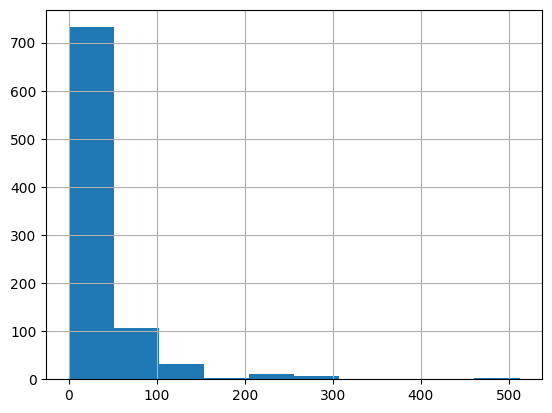

In [13]:
# histogram of fare data
# long tail to the right histogram
df['Fare'].hist();

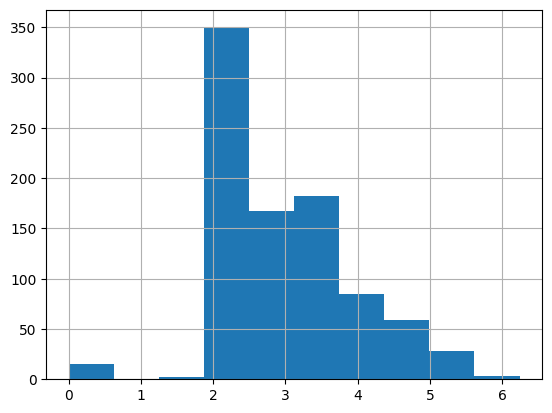

In [14]:
# log histogram of fare data to center data
df['LogFare'] = np.log(df['Fare'] + 1)
df['LogFare'].hist();

### Exploratory Data Analysis: Categorical Data

In [15]:
# Passenger Classes
pclasses = sorted(df.Pclass.unique())
pclasses

[1, 2, 3]

In [16]:
# non-numeric data summary
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


In [17]:
# Convert Categorical Data to Numerical Data - Dummy Variables
# - Dummy variable is a column that contains 1 where a particular columns contains a particular value
# and 0 otherwise

In [18]:
# create dummy variables for categorical variables
df = pd.get_dummies(df, columns=["Sex","Pclass","Embarked"])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [19]:
# new data with dummy variables
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
df[added_cols].head()

,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,0,0,1,0,0,1
1,0,1,1,0,0,1,0,0
2,0,1,0,0,1,0,0,1
3,0,1,1,0,0,0,0,1
4,1,0,0,0,1,0,0,1


## Linear Model

### Linear Model Variables

- **Independent Variables** - predictors: all continuous variables + dummy variables
- **Dependent Variables** - target: survived

In [20]:
# Linear Model Data Processing
from torch import tensor

# independent(predictors)
indep_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_cols
t_indep = tensor(df[indep_cols].values, dtype=torch.float)

# dependent(target) variables - Survived
t_dep = tensor(df.Survived)

# print information about tensors
print(f"Indendent Tensors Shape: {t_indep.shape}")
print(f"Independent Tensors Rank: {len(t_indep.shape)}")
print(f"Dependent Tensors Shape: {t_dep.shape}")
print(f"Dependent Tensors Rank: {len(t_dep.shape)}")

Indendent Tensors Shape: torch.Size([891, 12])
Independent Tensors Rank: 2
Dependent Tensors Shape: torch.Size([891])
Dependent Tensors Rank: 1


In [21]:
# do not use this in practice -> this is to ensure reproducibility in experimentation
# do not seed manually when done with experimentation
torch.manual_seed(442)

n_coeff = t_indep.shape[1]
coeffs = torch.rand(n_coeff) - 0.5
print(f"Coefficients shape: {coeffs.shape}")
print(f"Coefficients rank: {len(coeffs.shape)}")
print(f"Coefficients: {coeffs}")

Coefficients shape: torch.Size([12])
Coefficients rank: 1
Coefficients: tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625])


In [22]:
 # element wise multiplication using broadcasting - multiply every row by coefficients
#  - can be interpreted as looping 891 times and multiplying each row value by corresponding coeff value
t_indep * coeffs

tensor([[-10.1838,   0.1386,   0.0000,  -0.4772,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-17.5902,   0.1386,   0.0000,  -0.9681,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.4392,   0.0000,   0.0000],
        [-12.0354,   0.0000,   0.0000,  -0.4950,  -0.0000,  -0.3147,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.1386,   0.0000,  -0.9025,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.0000,   0.0000,  -0.4982,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-11.1096,   0.0000,   0.0000,  -0.5081,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.2103,   0.0000],
        [-24.9966,   0.0000,   0.0000,  -0.8973,  -0.2632,  -0.0000,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        ...,
        [-11.5725,   0.0000,   0.0000,  -0.4717,  -0.2632,  -0.0000,   0.0000

In [23]:
# Sum of each row are dominated by Age since Age is larger than all the other variables
# center data to between 0 and 1 by averaging each column

# find max val in each row
vals,indices = t_indep.max(dim=0)
print(f"vals shape {vals.shape}")
print(f"vals rank: {len(vals.shape)}")

# - can be interpreted as looping 891 times and dividing each row value by corresponding value in vals
t_indep = t_indep / vals

vals shape torch.Size([12])
vals rank: 1


In [24]:
# Recompute coefficients using new new centered independent variable values
t_indep * coeffs

tensor([[-0.1273,  0.0173,  0.0000, -0.0765, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2199,  0.0173,  0.0000, -0.1551, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.4392,  0.0000,  0.0000],
        [-0.1504,  0.0000,  0.0000, -0.0793, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0173,  0.0000, -0.1446, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0000,  0.0000, -0.0798, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.1389,  0.0000,  0.0000, -0.0814, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.2103,  0.0000],
        [-0.3125,  0.0000,  0.0000, -0.1438, -0.2632, -0.0000,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        ...,
        [-0.1447,  0.0000,  0.0000, -0.0756, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2257,  0.0000,  0.2008, -0.1234

In [25]:
# Calculate Prediction
preds = (t_indep * coeffs).sum(axis=1)
print(f"first few predictions: {preds[:10]}")

first few predictions: tensor([ 0.1927, -0.6239,  0.0979,  0.2056,  0.0968,  0.0066,  0.1306,  0.3476,  0.1613, -0.6285])


In [26]:
# Loss Function -> Mean Absolute Error
# - Loss function is required for doing gradient descent
loss = torch.abs(preds - t_dep).mean()
print(f"Loss: {loss}")

Loss: 0.5382388234138489


In [27]:
# Functions for computing predictions and loss

# Compute Predictions
def calc_preds(coeffs, indeps):
  return (indeps * coeffs).sum(axis=1)

# Compute Loss
def calc_loss(coeffs, indeps, deps):
  return torch.abs(calc_preds(coeffs, indeps) - deps).mean()

## Gradient Descent

In [28]:
# Tell pytorch to calculate gradients
coeffs.requires_grad_()

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625], requires_grad=True)

In [29]:
# Calculate loss
loss = calc_loss(coeffs, t_indep, t_dep)
loss

tensor(0.5382, grad_fn=<MeanBackward0>)

In [30]:
# Calculate gradients
loss.backward()

In [31]:
# Gradients
coeffs.grad

tensor([-0.0106,  0.0129, -0.0041, -0.0484,  0.2099, -0.2132, -0.1212, -0.0247,  0.1425, -0.1886, -0.0191,  0.2043])

In [32]:
# - each call to backward, gradients are added to the value stored in grad attribute
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
coeffs.grad

tensor([-0.0212,  0.0258, -0.0082, -0.0969,  0.4198, -0.4265, -0.2424, -0.0494,  0.2851, -0.3771, -0.0382,  0.4085])

In [33]:
# reset gradients to zero after doing a single gradient step
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
with torch.no_grad():
  coeffs.sub_(coeffs.grad * 0.1)
  coeffs.grad.zero_()
  print(calc_loss(coeffs, t_indep, t_dep))

tensor(0.4945)


## Linear Model Training

In [34]:
# Data split
from fastai.data.transforms import RandomSplitter
trn_split,val_split=RandomSplitter(seed=42)(df)

print(f"Training Data Size: {len(trn_split)}")
print(f"Validation Data Size: {len(val_split)}")
print(f"Training Data Indices: {trn_split}")
print(f"Validation Data Indices: {val_split}")

Training Data Size: 713
Validation Data Size: 178
Training Data Indices: [788, 525, 821, 253, 374, 98, 215, 313, 281, 305, 701, 812, 76, 50, 387, 47, 516, 564, 434, 117, 150, 513, 676, 470, 569, 603, 816, 719, 120, 88, 204, 617, 615, 61, 648, 139, 840, 831, 302, 118, 58, 257, 404, 24, 618, 730, 371, 104, 370, 592, 548, 633, 216, 682, 157, 103, 512, 574, 650, 312, 757, 225, 241, 557, 808, 827, 334, 208, 23, 2, 28, 319, 463, 77, 34, 637, 842, 30, 460, 888, 217, 405, 10, 66, 852, 291, 249, 872, 75, 450, 597, 377, 178, 207, 737, 318, 573, 64, 415, 220, 184, 49, 384, 97, 121, 111, 568, 873, 343, 495, 611, 712, 723, 829, 871, 29, 641, 69, 844, 383, 560, 394, 817, 643, 820, 832, 409, 645, 441, 732, 636, 848, 475, 317, 884, 881, 367, 562, 689, 841, 805, 716, 81, 54, 44, 136, 364, 35, 796, 373, 342, 550, 543, 851, 185, 85, 451, 826, 761, 399, 16, 125, 264, 162, 197, 309, 804, 42, 545, 846, 622, 177, 273, 559, 815, 74, 248, 809, 403, 728, 613, 96, 549, 258, 192, 780, 263, 109, 803, 20, 715, 487,

In [35]:
# Training Data, Validation Data
trn_indep, val_indep = t_indep[trn_split], t_indep[val_split]
trn_dep, val_dep = t_dep[trn_split], t_dep[val_split]

print(f"Training Independent Data Size: {len(trn_indep)}")
print(f"Training Dependent Data Size: {len(trn_dep)}")
print(f"Validation Indepdent Data Size: {len(val_indep)}")
print(f"Validation Dependent Data Size: {len(val_dep)}")

Training Independent Data Size: 713
Training Dependent Data Size: 713
Validation Indepdent Data Size: 178
Validation Dependent Data Size: 178


In [36]:
# Randomly initialize coefficients
def init_coeffs():
  return (torch.rand(n_coeff) - 0.5).requires_grad_()

# Update coefficents
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)
    coeffs.grad.zero_()

# One full gradient descent step
def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad():
        update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

# Train model
def train_model(epochs=30, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs):
      one_epoch(coeffs, lr=lr)
    return coeffs

# Calculate average accuracy of model
def acc(coeffs):
  return (val_dep.bool() == (calc_preds(coeffs, val_indep) > 0.5)).float().mean()

# Show coefficients for each column
def show_coeffs():
  return dict(zip(indep_cols, coeffs.requires_grad_(False)))

In [37]:
# Train Model
coeffs = train_model(18, lr=0.2)

0.536; 0.502; 0.477; 0.454; 0.431; 0.409; 0.388; 0.367; 0.349; 0.336; 0.330; 0.326; 0.329; 0.304; 0.314; 0.296; 0.300; 0.289; 

In [38]:
# Coefficients for every column
show_coeffs()

{'Age': tensor(-0.2694),
 'SibSp': tensor(0.0901),
 'Parch': tensor(0.2359),
 'LogFare': tensor(0.0280),
 'Sex_male': tensor(-0.3990),
 'Sex_female': tensor(0.2345),
 'Pclass_1': tensor(0.7232),
 'Pclass_2': tensor(0.4112),
 'Pclass_3': tensor(0.3601),
 'Embarked_C': tensor(0.0955),
 'Embarked_Q': tensor(0.2395),
 'Embarked_S': tensor(0.2122)}

In [39]:
# Calculate accuracy
preds = calc_preds(coeffs, val_indep)

# - assume that any passenger with score > 0.5 is predicted to survive
# - correct for  each row where preds > 0.5 is the same as dependent variable
results = val_dep.bool()==(preds > 0.5)
print(f"First 16 results: {results[:16]}")

# Average accuracy
avg_acc = results.float().mean()
print(f"Average Accuracy: {avg_acc}")

First 16 results: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True, False, False, False,  True,  True, False])
Average Accuracy: 0.7865168452262878


## Sigmoid

In [40]:
# - some of the predictions of the survival probability are > 1 or < 0
# - can fix this issue by passing prediction through sigmoid function
preds[:28]

tensor([ 0.8160,  0.1295, -0.0148,  0.1831,  0.1520,  0.1350,  0.7279,  0.7754,  0.3222,  0.6740,  0.0753,  0.0389,  0.2216,  0.7631,
         0.0678,  0.3997,  0.3324,  0.8278,  0.1078,  0.7126,  0.1023,  0.3627,  0.9937,  0.8050,  0.1153,  0.1455,  0.8652,  0.3425])

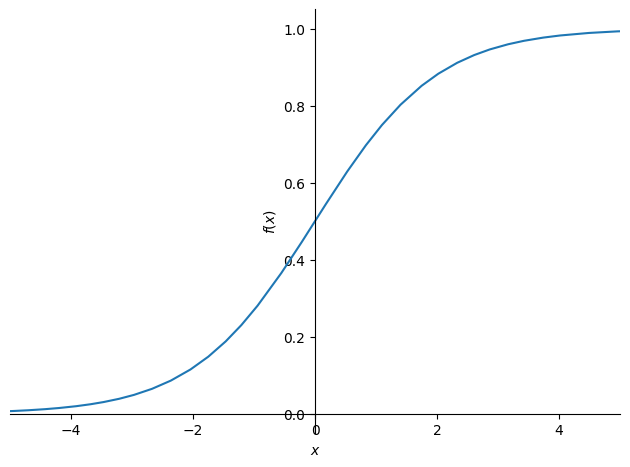

In [41]:
# Sigmoid function has a minimum of 0 and max at 1
import sympy
sympy.plot("1/(1+exp(-x))", xlim=(-5,5));

In [42]:
# Update calc predictions to use sigmoid
def calc_preds(coeffs, indeps):
  return torch.sigmoid((indeps*coeffs).sum(axis=1))

In [43]:
# Train Model with Sigmoid Predictions
coeffs = train_model(lr=100)

0.510; 0.327; 0.294; 0.207; 0.201; 0.199; 0.198; 0.197; 0.196; 0.196; 0.196; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 

In [44]:
# check coeffcients
show_coeffs()

{'Age': tensor(-1.5061),
 'SibSp': tensor(-1.1575),
 'Parch': tensor(-0.4267),
 'LogFare': tensor(0.2543),
 'Sex_male': tensor(-10.3320),
 'Sex_female': tensor(8.4185),
 'Pclass_1': tensor(3.8389),
 'Pclass_2': tensor(2.1398),
 'Pclass_3': tensor(-6.2331),
 'Embarked_C': tensor(1.4771),
 'Embarked_Q': tensor(2.1168),
 'Embarked_S': tensor(-4.7958)}

In [45]:
# Check Accuracy
acc(coeffs)

tensor(0.8258)

## Final Linear Model

In [46]:
# number of coefficients
n_coeff = t_indep.shape[1]

# Randomly initialize coefficients
def init_coeffs():
  return (torch.rand(n_coeff)-0.5).requires_grad_()

# Loss Function - MAE (Mean Absolute Error)
def calc_loss(coeffs, indeps, deps):
  return torch.abs(calc_preds(coeffs, indeps) - deps).mean()

# Update coefficents
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)
    coeffs.grad.zero_()

# One full gradient descent step
def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad():
      update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

# Train model
def train_model(epochs=30, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs):
      one_epoch(coeffs, lr=lr)
    return coeffs

# Calculate average accuracy of model
def acc(coeffs):
  return (val_dep.bool() == (calc_preds(coeffs, val_indep) > 0.5)).float().mean()
acc(coeffs)

# Calculate predictions
def calc_preds(coeffs, indeps):
  return torch.sigmoid((indeps * coeffs).sum(axis=1))

# Show coefficients for each column
def show_coeffs():
  return dict(zip(indep_cols, coeffs.requires_grad_(False)))

In [47]:
coeffs = train_model(lr=100)

0.510; 0.327; 0.294; 0.207; 0.201; 0.199; 0.198; 0.197; 0.196; 0.196; 0.196; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 

## Test model on inference data

### Inference Data Processing

In [48]:
# load data
tst_df = pd.read_csv(path/'test.csv')

# Fare data is missing one passenger -> substitute 0 to fix the issue
tst_df['Fare'] = tst_df.Fare.fillna(0)
tst_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [49]:
# - these steps follow the same process as the training data processing
tst_df.fillna(modes, inplace=True)
tst_df['LogFare'] = np.log(tst_df['Fare'] + 1)
tst_df = pd.get_dummies(tst_df, columns=["Sex","Pclass","Embarked"])

added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
indep_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_cols

tst_indep = tensor(tst_df[indep_cols].values, dtype=torch.float)
tst_indep = tst_indep / vals

In [50]:
# Calculate predictions of which passengers survived in titanic dataset
tst_df['Survived'] = (calc_preds(tst_indep, coeffs) > 0.5).int()

## Linear Model: Submit Results to Kaggle

In [51]:
# Submit to Kaggle
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('sub.csv', index=False)

# check first few rows
!head sub.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,0
897,0
898,1
899,0
900,1


## Cleaning up Linear Model Code

In [52]:
# - Multiplying elements together and then adding across rows is the same as matrix-vector multiply

In [53]:
# Original Matrix-Vector multiply
(val_indep*coeffs).sum(axis=1)

tensor([ 12.3288, -14.8119, -15.4540, -13.1513, -13.3512, -13.6469,   3.6248,   5.3429, -22.0878,   3.1233, -21.8742, -15.6421, -21.5504,
          3.9393, -21.9190, -12.0010, -12.3775,   5.3550, -13.5880,  -3.1015, -21.7237, -12.2081,  12.9767,   4.7427, -21.6525, -14.9135,
         -2.7433, -12.3210, -21.5886,   3.9387,   5.3890,  -3.6196, -21.6296, -21.8454,  12.2159,  -3.2275, -12.0289,  13.4560, -21.7230,
         -3.1366, -13.2462, -21.7230, -13.6831,  13.3092, -21.6477,  -3.5868, -21.6854, -21.8316, -14.8158,  -2.9386,  -5.3103, -22.2384,
        -22.1097, -21.7466, -13.3780, -13.4909, -14.8119, -22.0690, -21.6666, -21.7818,  -5.4439, -21.7407, -12.6551, -21.6671,   4.9238,
        -11.5777, -13.3323, -21.9638, -15.3030,   5.0243, -21.7614,   3.1820, -13.4721, -21.7170, -11.6066, -21.5737, -21.7230, -11.9652,
        -13.2382, -13.7599, -13.2170,  13.1347, -21.7049, -21.7268,   4.9207,  -7.3198,  -5.3081,   7.1065,  11.4948, -13.3135, -21.8723,
        -21.7230,  13.3603, -15.56

In [54]:
# Pytorch optimized matrix-vector multiply
# - python uses @ operator to indicate matrix products and is supported by pytorch tensors
val_indep@coeffs

tensor([ 12.3288, -14.8119, -15.4540, -13.1513, -13.3511, -13.6468,   3.6248,   5.3429, -22.0878,   3.1233, -21.8742, -15.6421, -21.5504,
          3.9393, -21.9190, -12.0010, -12.3775,   5.3550, -13.5880,  -3.1015, -21.7237, -12.2081,  12.9767,   4.7427, -21.6525, -14.9135,
         -2.7433, -12.3210, -21.5886,   3.9387,   5.3890,  -3.6196, -21.6296, -21.8454,  12.2159,  -3.2275, -12.0289,  13.4560, -21.7230,
         -3.1366, -13.2462, -21.7230, -13.6831,  13.3092, -21.6477,  -3.5868, -21.6854, -21.8316, -14.8158,  -2.9386,  -5.3103, -22.2384,
        -22.1097, -21.7466, -13.3780, -13.4909, -14.8119, -22.0690, -21.6666, -21.7818,  -5.4439, -21.7407, -12.6551, -21.6671,   4.9238,
        -11.5777, -13.3323, -21.9638, -15.3030,   5.0243, -21.7614,   3.1820, -13.4721, -21.7170, -11.6066, -21.5737, -21.7230, -11.9652,
        -13.2382, -13.7599, -13.2170,  13.1347, -21.7049, -21.7268,   4.9207,  -7.3198,  -5.3081,   7.1065,  11.4948, -13.3135, -21.8723,
        -21.7230,  13.3603, -15.56

### Linear Model - PyTorch Matrix-Vector Multiply

In [55]:
# number of coefficients
n_coeff = t_indep.shape[1]

# Randomly initialize coefficients
def init_coeffs():
  # - 1 turns torch.rand() into a column vector
  return (torch.rand(n_coeff, 1) * 0.1).requires_grad_()

# Loss Function - MAE (Mean Absolute Error)
def calc_loss(coeffs, indeps, deps):
  return torch.abs(calc_preds(coeffs, indeps) - deps).mean()

# Update coefficents
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)
    coeffs.grad.zero_()

# One full gradient descent step
def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad():
      update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

# Train model
def train_model(epochs=30, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs):
      one_epoch(coeffs, lr=lr)
    return coeffs

# Calculate average accuracy of model
def acc(coeffs):
  return (val_dep.bool() == (calc_preds(coeffs, val_indep) > 0.5)).float().mean()
acc(coeffs)

# Calculate predictions
def calc_preds(coeffs, indeps):
  return torch.sigmoid(indeps@coeffs)

# Show coefficients for each column
def show_coeffs():
  return dict(zip(indep_cols, coeffs.requires_grad_(False)))

In [56]:
# change dependent variable into a column vector - rank 2 tensor
trn_dep = trn_dep[:,None]
val_dep = val_dep[:,None]
print(f"Training Data Shape: {trn_dep.shape}")
print(f"Training Data Rank: {len(trn_dep.shape)}")
print(f"Validation Data Shape: {val_dep.shape}")
print(f"Validation Data Rank: {len(val_dep.shape)}")

Training Data Shape: torch.Size([713, 1])
Training Data Rank: 2
Validation Data Shape: torch.Size([178, 1])
Validation Data Rank: 2


In [57]:
coeffs = train_model(lr=100)
print()
print(f"coefficients shape: {coeffs.shape}")
print(f"coefficients rank: {len(coeffs.shape)}")
print(f"accuracy: {acc(coeffs)}")


0.512; 0.323; 0.290; 0.205; 0.200; 0.198; 0.197; 0.197; 0.196; 0.196; 0.196; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 
coefficients shape: torch.Size([12, 1])
coefficients rank: 2
accuracy: 0.8258426785469055


## Neural Network

In [58]:
# Define coefficients for each layer of the neural network

# - n hidden -> higher number gives more flexibility for neural network to approximate data
# but slower and harder to train

# First Layer
# input -> n_coeff values
# output -> n_hidden values (input to second layer)
# - need matrix of size n_coeffs by n_hidden
# - divide coefficients by n_hidden so that when we sum them up in the next layer we
# end up with similar magnitude numbers to what we started with

# Second Layer
# input -> n_hidden values (output of first layer)
# output -> 1 value
# - need n_hidden by 1 + constant term

# Steps
# 1. Two matrix products - indeps@l1 and res@l2 (res is output of first layer)
# 2. First layer output is passed to F.relu (non-linearity)
# 3. Second layer output is passed to sigmoid

In [59]:
def init_coeffs(n_hidden=20):
  # set of coefficients to go from input to hidden
    layer1 = (torch.rand(n_coeff, n_hidden) - 0.5) / n_hidden

    # set of coefficients to from hiddent to an output
    layer2 = torch.rand(n_hidden, 1) - 0.3
    const = torch.rand(1)[0]

    # return a tuple of layer1 gradient, layer2 gradient, and constant gradient
    return layer1.requires_grad_(), layer2.requires_grad_(), const.requires_grad_()

In [60]:
import torch.nn.functional as F

# neural network
def calc_preds(coeffs, indeps):
    l1, l2, const = coeffs

    # layer 1
    # replace negative values with zeroes
    res = F.relu(indeps@l1)

    # layer 2
    res = res@l2 + const
    return torch.sigmoid(res)

In [61]:
# Update Coefficients
# - Three sets of coefficients to update per epoch(layer1, layer2, constant)
def update_coeffs(coeffs, lr):
  for layer in coeffs:
    layer.sub_(layer.grad * lr)
    layer.grad.zero_()

In [62]:
# Train Model
coeffs = train_model(lr=1.4)

0.543; 0.532; 0.520; 0.505; 0.487; 0.466; 0.439; 0.407; 0.373; 0.343; 0.319; 0.301; 0.286; 0.274; 0.264; 0.256; 0.250; 0.245; 0.240; 0.237; 0.234; 0.231; 0.229; 0.227; 0.226; 0.224; 0.223; 0.222; 0.221; 0.220; 

In [63]:
# Train Model
coeffs = train_model(lr=20)

0.543; 0.400; 0.260; 0.390; 0.221; 0.211; 0.197; 0.195; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 

In [64]:
# Check Accuracy
acc(coeffs)

tensor(0.8258)

## Deep Learning

In [65]:
def init_coeffs():
  # size of each hidden layer
  # two hidden layers - 10 activations in each layer
    hiddens = [10, 10]
  # - n_coeffs to 10
  # - 10 to 10
  # - 10 to 1
    sizes = [n_coeff] + hiddens + [1]
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i + 1])- 0.3)/sizes[i + 1]*4 for i in range(n - 1)]
    consts = [(torch.rand(1)[0] - 0.5) * 0.1 for i in range(n - 1)]
    for l in layers + consts:
      l.requires_grad_()
    return layers,consts

In [66]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    layers,consts = coeffs
    n = len(layers)
    res = indeps
    for i,l in enumerate(layers):
        res = res@l + consts[i]
        # RELU for every layer except for last layer
        if i != n - 1:
          res = F.relu(res)
        # sigmoid only for the last layer
    return torch.sigmoid(res)

In [67]:
def update_coeffs(coeffs, lr):
    layers,consts = coeffs
    for layer in layers + consts:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

In [68]:
# Train Model
coeffs = train_model(lr=4)

0.521; 0.483; 0.427; 0.379; 0.379; 0.379; 0.379; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.377; 0.376; 0.371; 0.333; 0.239; 0.224; 0.208; 0.204; 0.203; 0.203; 0.207; 0.197; 0.196; 0.195; 

In [69]:
# Check Accuracy
acc(coeffs)

tensor(0.8258)

## Framework: fastai + PyTorch

In [70]:
# load stuff
from fastai.tabular.all import *

pd.options.display.float_format = '{:.2f}'.format
set_seed(42)


In [71]:
# Load Data
df = pd.read_csv(path/'train.csv')

# Feature Engineering
def add_features(df):
    df['LogFare'] = np.log1p(df['Fare'])
    df['Deck'] = df.Cabin.str[0].map(dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
    df['Family'] = df.SibSp+df.Parch
    df['Alone'] = df.Family==0
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    df['Title'] = df.Title.map(dict(Mr="Mr",Miss="Miss",Mrs="Mrs",Master="Master"))

add_features(df)

In [72]:
# Data Split
splits = RandomSplitter(seed=42)(df)

In [73]:
# Tabular Dataloaders
dls = TabularPandas(
    # splits for indices of training and validation sets
    df, splits=splits,
    # Turn strings into categories, fill missing values in numeric columns with the median, normalise all numeric columns
    procs = [Categorify, FillMissing, Normalize],
    # categorical independent variables
    cat_names=["Sex","Pclass","Embarked","Deck", "Title"],
    # continuous independent variables
    cont_names=['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family'],
    # dependent variable
    y_names="Survived",
    # dependent variable is categorical(build a classification model)
    y_block = CategoryBlock(),
).dataloaders(path=".")



/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


In [74]:
# Train Model
# - data + model = Learner
# - dls -> data
# - layers -> size of each hidden layer
# - metrics -> any metric we want to use for loss function
learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_co

SuggestedLRs(slide=0.05754399299621582, valley=0.013182567432522774)

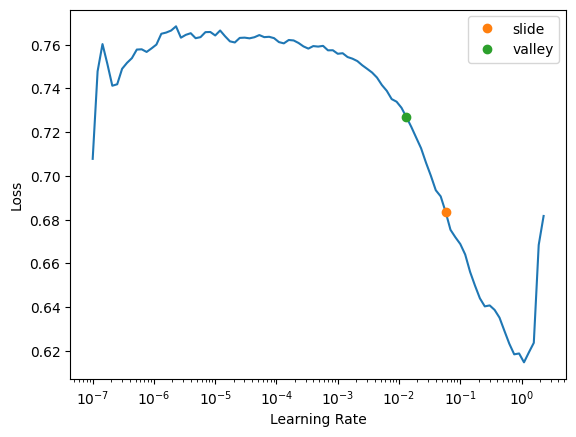

In [75]:
# find learning rate
learn.lr_find(suggest_funcs=(slide, valley))

In [76]:
# specify number of epochs and learning rate and train model
learn.fit(16, 0.03)

epoch,train_loss,valid_loss,accuracy,time
0,0.577146,0.582949,0.606742,00:00
1,0.510818,0.498523,0.786517,00:00
2,0.467023,0.459841,0.797753,00:00
3,0.439957,0.468547,0.797753,00:00
4,0.427232,0.415261,0.825843,00:00
5,0.416340,0.437362,0.820225,00:00
6,0.408347,0.413253,0.848315,00:00
7,0.400442,0.406075,0.803371,00:00
8,0.397265,0.443730,0.820225,00:00
9,0.392389,0.432267,0.831461,00:00


/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_co

## Test fastai model on inference data

In [77]:
# Inference Data Processing
tst_df = pd.read_csv(path/'test.csv')
tst_df['Fare'] = tst_df.Fare.fillna(0)
add_features(tst_df)

In [78]:
# apply data modeling information from learner to inference
tst_dl = learn.dls.test_dl(tst_df)

In [79]:
# get predictions for the inference data
preds,_ = learn.get_preds(dl=tst_dl)

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_co

## FastAI Model: Submit to Kaggle

In [80]:
# submit to kaggle
tst_df['Survived'] = (preds[:,1] > 0.5).int()
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('framework_sub.csv', index=False)

# check predictions file
!head framework_sub.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,1
897,0
898,1
899,0
900,1


## Ensembling

In [81]:
# Ensembling
# - create multiple models and combine predictions

In [82]:
def ensemble():
    learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])
    with learn.no_bar(),learn.no_logging():
      learn.fit(16, lr=0.03)
    return learn.get_preds(dl=tst_dl)[0]

In [83]:
# create a set of 5 different predictions
learns = [ensemble() for _ in range(5)]

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_co

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_co

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_co

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_co

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_co

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_co

In [84]:
# take average of all predictions
ens_preds = torch.stack(learns).mean(0)

## Ensembling: Submit to Kaggle

In [85]:
# submit to kaggle
tst_df['Survived'] = (preds[:,1] > 0.5).int()
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('ensemble_sub.csv', index=False)

# check predictions file
!head ensemble_sub.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,1
897,0
898,1
899,0
900,1


## Resources

1. [FastAI Lesson 3](https://www.youtube.com/watch?v=hBBOjCiFcuo)
2. [FastAI Lesson 5](https://www.youtube.com/watch?v=_rXzeWq4C6w)
3. [FastAI Chapter 4](https://nbviewer.org/github/fastai/fastbook/blob/master/04_mnist_basics.ipynb)
4. [How does a neural net really work?](https://www.kaggle.com/code/jhoward/how-does-a-neural-net-really-work)
5. [Linear model and neural net from scratch](https://www.kaggle.com/code/jhoward/linear-model-and-neural-net-from-scratch)
6. [Why you should use a framework](https://www.kaggle.com/code/jhoward/why-you-should-use-a-framework)
7. [Titanic - Advanced Feature Engineering Tutorial](https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial/)
8. [Titanic - Machine Learning from Disaster](https://www.kaggle.com/competitions/titanic)
9. [fast.ai library](https://docs.fast.ai/)
